In [1]:
import logging
from typing import List

import numpy as np
from rlbench.backend.observation import Observation
from rlbench.observation_config import ObservationConfig
import rlbench.utils as rlbench_utils
from rlbench.demo import Demo
from yarr.replay_buffer.prioritized_replay_buffer import ObservationElement
from yarr.replay_buffer.replay_buffer import ReplayElement, ReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer import UniformReplayBuffer
from yarr.replay_buffer.task_uniform_replay_buffer import TaskUniformReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer_single_process import UniformReplayBufferSingleProcess
from helpers import demo_loading_utils, utils
from helpers.preprocess_agent import PreprocessAgent
from helpers.clip.core.clip import tokenize
from helpers.language_model import create_language_model
from helpers.utils import create_obs_config

from agents.manigaussian_bc.perceiver_lang_io import PerceiverVoxelLangEncoder
from agents.manigaussian_bc.qattention_manigaussian_bc_agent import QAttentionPerActBCAgent
from agents.manigaussian_bc.qattention_stack_agent import QAttentionStackAgent

import torch
import torch.nn as nn
import multiprocessing as mp
from torch.multiprocessing import Process, Value, Manager
from omegaconf import DictConfig
from termcolor import colored, cprint
from lightning.fabric import Fabric

/home/bruce/anaconda3/envs/manigaussian/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [112]:
import hydra
from omegaconf import DictConfig, OmegaConf
from pathlib import Path

@hydra.main(config_path="conf/", config_name="config")

def main(config):
    running_dir = str(hydra.utils.get_original_cwd())
    working_dir = str(Path.cwd())
    print(f"The current running directory is {running_dir}")
    print(f"The current working directory is {working_dir}")

    # To access elements of the config
    print(f"The batch size is {config.batch_size}")
    print(f"The learning rate is {config['lr']}")

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [--help] [--hydra-help] [--version]
                             [--cfg {job,hydra,all}] [--resolve]
                             [--package PACKAGE] [--run] [--multirun]
                             [--shell-completion] [--config-path CONFIG_PATH]
                             [--config-name CONFIG_NAME]
                             [--config-dir CONFIG_DIR]
                             [--info [{all,config,defaults,defaults-tree,plugins,searchpath}]]
                             [overrides ...]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/bruce/.local/share/jupyter/runtime/kernel-v2-703797Y9HT4S7BH8.json


SystemExit: 2

In [ ]:
from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(config_path="conf/"):
    cfg = compose(config_name='config.yaml')
    method_cfg = compose(config_name='method/ManiGaussian_BC.yaml')
    cfg.method = method_cfg.method
    # print(cfg.method)
    print(OmegaConf.to_yaml(cfg))

In [85]:

REWARD_SCALE = 100.0
LOW_DIM_SIZE = 4

def create_replay(batch_size: int, 
                  timesteps: int,
                  prioritisation: bool, 
                  task_uniform: bool,
                  save_dir: str, 
                  cameras: list,
                  voxel_sizes,
                  image_size=[128, 128],
                  replay_size=3e5,
                  single_process=False,
                  cfg=None,):

    trans_indicies_size = 3 * len(voxel_sizes)
    rot_and_grip_indicies_size = (3 + 1)
    gripper_pose_size = 7
    ignore_collisions_size = 1
    max_token_seq_len = 77
    lang_feat_dim = 1024
    lang_emb_dim = 512
    cprint(f"[create_replay] lang_emb_dim: {lang_emb_dim}", "green")

    num_view_for_nerf = 21
    
    # low_dim_state
    observation_elements = []
    observation_elements.append(
        ObservationElement('low_dim_state', (LOW_DIM_SIZE,), np.float32))

    # rgb, depth, point cloud, intrinsics, extrinsics
    for cname in cameras:
        observation_elements.append(
            ObservationElement('%s_rgb' % cname, (3, *image_size,), np.float32))
        observation_elements.append(
            ObservationElement('%s_depth' % cname, (1, *image_size,), np.float32))
        observation_elements.append(
            ObservationElement('%s_point_cloud' % cname, (3, *image_size),
                               np.float32))  # see pyrep/objects/vision_sensor.py on how pointclouds are extracted from depth frames
        observation_elements.append(
            ObservationElement('%s_camera_extrinsics' % cname, (4, 4,), np.float32))
        observation_elements.append(
            ObservationElement('%s_camera_intrinsics' % cname, (3, 3,), np.float32))

    # for nerf img, exs, ins
    observation_elements.append(
        ObservationElement('nerf_multi_view_rgb', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_multi_view_depth', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_multi_view_camera', (num_view_for_nerf,), np.object_))
    
    # for next nerf
    observation_elements.append(
        ObservationElement('nerf_next_multi_view_rgb', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_next_multi_view_depth', (num_view_for_nerf,), np.object_))
    observation_elements.append(
        ObservationElement('nerf_next_multi_view_camera', (num_view_for_nerf,), np.object_))

    # discretized translation, discretized rotation, discrete ignore collision, 6-DoF gripper pose, and pre-trained language embeddings
    observation_elements.extend([
        ReplayElement('trans_action_indicies', (trans_indicies_size,),
                      np.int32),
        ReplayElement('rot_grip_action_indicies', (rot_and_grip_indicies_size,),
                      np.int32),
        ReplayElement('ignore_collisions', (ignore_collisions_size,),
                      np.int32),
        ReplayElement('gripper_pose', (gripper_pose_size,),
                      np.float32),
        ReplayElement('lang_goal_emb', (lang_feat_dim,),
                      np.float32),
        ReplayElement('lang_token_embs', (max_token_seq_len, lang_emb_dim,),
                      np.float32), # extracted from CLIP's language encoder
        ReplayElement('task', (),
                      str),
        ReplayElement('lang_goal', (1,),
                      object),  # language goal string for debugging and visualization
    ])

    extra_replay_elements = [
        ReplayElement('demo', (), np.bool),
    ]
    if not single_process:  # default: False
        replay_buffer = TaskUniformReplayBuffer(
            save_dir=save_dir,
            batch_size=batch_size,
            timesteps=timesteps,
            replay_capacity=int(replay_size),
            action_shape=(8,),
            action_dtype=np.float32,
            reward_shape=(),
            reward_dtype=np.float32,
            update_horizon=1,
            observation_elements=observation_elements,
            extra_replay_elements=extra_replay_elements,
        )
    else:
        replay_buffer = UniformReplayBufferSingleProcess(
            save_dir=save_dir,
            batch_size=batch_size,
            timesteps=timesteps,
            replay_capacity=int(replay_size),
            action_shape=(8,),
            action_dtype=np.float32,
            reward_shape=(),
            reward_dtype=np.float32,
            update_horizon=1,
            observation_elements=observation_elements,
            extra_replay_elements=extra_replay_elements
        )
    return replay_buffer


def _get_action(
        obs_tp1: Observation,
        obs_tm1: Observation,
        rlbench_scene_bounds: List[float], # metric 3D bounds of the scene
        voxel_sizes: List[int],
        bounds_offset: List[float],
        rotation_resolution: int,
        crop_augmentation: bool):
    '''
    obs_tp1: current observation
    obs_tm1: previous observation
    '''
    quat = utils.normalize_quaternion(obs_tp1.gripper_pose[3:])
    if quat[-1] < 0:
        quat = -quat
    disc_rot = utils.quaternion_to_discrete_euler(quat, rotation_resolution)
    disc_rot = utils.correct_rotation_instability(disc_rot, rotation_resolution)

    attention_coordinate = obs_tp1.gripper_pose[:3]
    trans_indicies, attention_coordinates = [], []
    bounds = np.array(rlbench_scene_bounds)
    ignore_collisions = int(obs_tm1.ignore_collisions)
    for depth, vox_size in enumerate(voxel_sizes): # only single voxelization-level is used in PerAct
        if depth > 0:
            if crop_augmentation:
                shift = bounds_offset[depth - 1] * 0.75
                attention_coordinate += np.random.uniform(-shift, shift, size=(3,))
            bounds = np.concatenate([attention_coordinate - bounds_offset[depth - 1],
                                     attention_coordinate + bounds_offset[depth - 1]])
        index = utils.point_to_voxel_index(
            obs_tp1.gripper_pose[:3], vox_size, bounds)
        trans_indicies.extend(index.tolist())
        res = (bounds[3:] - bounds[:3]) / vox_size
        attention_coordinate = bounds[:3] + res * index
        attention_coordinates.append(attention_coordinate)

    rot_and_grip_indicies = disc_rot.tolist()
    grip = float(obs_tp1.gripper_open)
    rot_and_grip_indicies.extend([int(obs_tp1.gripper_open)])
    return trans_indicies, rot_and_grip_indicies, ignore_collisions, np.concatenate(
        [obs_tp1.gripper_pose, np.array([grip])]), attention_coordinates


def _add_keypoints_to_replay(
        # cfg: DictConfig,
        task: str,
        replay: ReplayBuffer,
        inital_obs: Observation,
        demo: Demo,
        episode_keypoints: List[int],
        cameras: List[str],
        rlbench_scene_bounds: List[float],
        voxel_sizes: List[int],
        bounds_offset: List[float],
        rotation_resolution: int,
        crop_augmentation: bool,
        description: str = '',
        language_model = None,
        device = 'cpu'):
    prev_action = None
    obs = inital_obs    # initial observation is 0

   
    for k, keypoint in enumerate(episode_keypoints):    # demo[-1].nerf_multi_view_rgb is None
        obs_tp1 = demo[keypoint]    # e.g, 44

        obs_tm1 = demo[max(0, keypoint - 1)]    # previous observation, e.g., 43

        trans_indicies, rot_grip_indicies, ignore_collisions, action, attention_coordinates = _get_action(
            obs_tp1, obs_tm1, rlbench_scene_bounds, voxel_sizes, bounds_offset,
            rotation_resolution, crop_augmentation)

        terminal = (k == len(episode_keypoints) - 1)
        reward = float(terminal) * REWARD_SCALE if terminal else 0

        obs_dict = utils.extract_obs(obs, t=k, prev_action=prev_action,
                                     cameras=cameras, episode_length=15,
                                     next_obs=obs_tp1 if not terminal else obs_tm1,
                                     )
        # FIXME: better way to use the last sample for next frame prediction?
        sentence_emb, token_embs = language_model.extract(description)

        obs_dict['lang_goal_emb'] = sentence_emb[0].float().detach().cpu().numpy()
        obs_dict['lang_token_embs'] = token_embs[0].float().detach().cpu().numpy()
        obs_dict['lang_goal'] = np.array([description], dtype=object) # add this for usage in diffusion model

        prev_action = np.copy(action)

        others = {'demo': True}
        final_obs = {
            'trans_action_indicies': trans_indicies,
            'rot_grip_action_indicies': rot_grip_indicies,
            'gripper_pose': obs_tp1.gripper_pose,
            'task': task,
            'lang_goal': np.array([description], dtype=object),
        }

        others.update(final_obs)
        others.update(obs_dict)

        timeout = False
        replay.add(action, reward, terminal, timeout, **others)
        obs = obs_tp1

    # final step
    obs_dict_tp1 = utils.extract_obs(obs_tp1, t=k + 1, prev_action=prev_action,
                                     cameras=cameras, episode_length=15,
                                     next_obs=obs_tp1,  
                                     )
    # nerf_multi_view_rgb is None
    obs_dict_tp1['lang_goal_emb'] = sentence_emb[0].float().detach().cpu().numpy()
    obs_dict_tp1['lang_token_embs'] = token_embs[0].float().detach().cpu().numpy()
    obs_dict_tp1['lang_goal'] = np.array([description], dtype=object) # add this for usage in diffusion model

    obs_dict_tp1.pop('wrist_world_to_cam', None)
    obs_dict_tp1.update(final_obs)
    # check nerf data here. find None
    replay.add_final(**obs_dict_tp1)


def fill_replay(
        # cfg: DictConfig,
                obs_config: ObservationConfig,
                rank: int,
                replay: ReplayBuffer,
                task: str,
                num_demos: int,
                demo_augmentation: bool,
                demo_augmentation_every_n: int,
                cameras: List[str],
                rlbench_scene_bounds: List[float],  # AKA: DEPTH0_BOUNDS
                voxel_sizes: List[int],
                bounds_offset: List[float],
                rotation_resolution: int,
                crop_augmentation: bool,
                language_model = None,
                device = 'cpu',
                keypoint_method = 'heuristic'):
    logging.getLogger().setLevel(20)        

    logging.debug('Filling %s replay ...' % task)
    for d_idx in range(num_demos):
        # load demo from disk
        demo = rlbench_utils.get_stored_demos(
            amount=1, image_paths=False,
            dataset_root='/home/bruce/Project/ManiGaussian/data/train_data',
            variation_number=-1, task_name=task,
            obs_config=obs_config,
            random_selection=False,
            from_episode_number=d_idx)[0]

        
        descs = demo._observations[0].misc['descriptions']

        # extract keypoints (a.k.a keyframes)
        episode_keypoints = demo_loading_utils.keypoint_discovery(demo, method=keypoint_method)

        if rank == 0:   # always 0
            logging.info(f"Loading Demo({d_idx}) - found {len(episode_keypoints)} keypoints - {task}")

        for i in range(len(demo) - 1):
            if not demo_augmentation and i > 0:
                break
            if i % demo_augmentation_every_n != 0:
                continue

            obs = demo[i]
           

            desc = descs[0]
            # if our starting point is past one of the keypoints, then remove it
            while len(episode_keypoints) > 0 and i >= episode_keypoints[0]:
                episode_keypoints = episode_keypoints[1:]
            if len(episode_keypoints) == 0:
                break
            

            _add_keypoints_to_replay(
                # cfg, 
                task, replay, obs, demo, episode_keypoints, cameras,
                rlbench_scene_bounds, voxel_sizes, bounds_offset,
                rotation_resolution, crop_augmentation, description=desc,
                language_model=language_model, device=device)
    logging.debug('Replay %s filled with demos.' % task)


def fill_multi_task_replay(
            # cfg: DictConfig,
            obs_config: ObservationConfig,
            rank: int,   # non-sense
            replay: ReplayBuffer,
            tasks: List[str],
            num_demos: int,
            demo_augmentation: bool,
            demo_augmentation_every_n: int,
            cameras: List[str],
            rlbench_scene_bounds: List[float],
            voxel_sizes: List[int],
            bounds_offset: List[float],
            rotation_resolution: int,
            crop_augmentation: bool,
            keypoint_method = 'heuristic',
            fabric: Fabric = None):
    manager = Manager()
    store = manager.dict()

    # create a MP dict for storing indicies
    # TODO(mohit): this shouldn't be initialized here
    if hasattr(replay, '_task_idxs'):
        del replay._task_idxs
    task_idxs = manager.dict()

    replay._task_idxs = task_idxs
    replay._create_storage(store)
    replay.add_count = Value('i', 0)

    # fill replay buffer in parallel across tasks
    max_parallel_processes = 8
    processes = []
    n = np.arange(len(tasks))
    split_n = utils.split_list(n, max_parallel_processes)
    
    device = fabric.device if fabric is not None else None
    language_model = create_language_model(name='CLIP', device=device)

    for split in split_n:
        for e_idx, task_idx in enumerate(split):
            task = tasks[int(task_idx)]
            model_device = torch.device('cuda:%s' % (e_idx % torch.cuda.device_count())
                                        if torch.cuda.is_available() else 'cpu')    # NOT USED
            # p = Process(target=fill_replay, args=(
            #     # cfg,
            #                                       obs_config,
            #                                       rank,
            #                                       replay,
            #                                       task,
            #                                       num_demos,
            #                                       demo_augmentation,
            #                                       demo_augmentation_every_n,
            #                                       cameras,
            #                                       rlbench_scene_bounds,
            #                                       voxel_sizes,
            #                                       bounds_offset,
            #                                       rotation_resolution,
            #                                       crop_augmentation,
            #                                       language_model,
            #                                       model_device,
            #                                       keypoint_method))
            fill_replay(
                # cfg,
                        obs_config,
                        rank,
                        replay,
                        task,
                        num_demos,
                        demo_augmentation,
                        demo_augmentation_every_n,
                        cameras,
                        rlbench_scene_bounds,
                        voxel_sizes,
                        bounds_offset,
                        rotation_resolution,
                        crop_augmentation,
                        language_model,
                        model_device,
                        keypoint_method)
        #     p.start()
        #     processes.append(p)

        # for p in processes:
        #     p.join()

In [86]:
obs_config = create_obs_config(['front'],
                                [128,128],
                                'ManiGaussian_BC',
                                use_depth=True,
                                )

In [87]:
obs_config.__dict__

{'left_shoulder_camera': <rlbench.observation_config.CameraConfig at 0x7ceca031a310>,
 'right_shoulder_camera': <rlbench.observation_config.CameraConfig at 0x7ceca031a310>,
 'overhead_camera': <rlbench.observation_config.CameraConfig at 0x7ceca031a310>,
 'wrist_camera': <rlbench.observation_config.CameraConfig at 0x7ceca031a310>,
 'front_camera': <rlbench.observation_config.CameraConfig at 0x7ceca031af40>,
 'nerf_multi_view': True,
 'joint_velocities': True,
 'joint_velocities_noise': <rlbench.noise_model.Identity at 0x7ced8a7d2d90>,
 'joint_positions': True,
 'joint_positions_noise': <rlbench.noise_model.Identity at 0x7ced8a7d2dc0>,
 'joint_forces': False,
 'joint_forces_noise': <rlbench.noise_model.Identity at 0x7ced8a7d2df0>,
 'gripper_open': True,
 'gripper_pose': True,
 'gripper_matrix': True,
 'gripper_joint_positions': True,
 'gripper_touch_forces': False,
 'wrist_camera_matrix': False,
 'record_gripper_closing': False,
 'task_low_dim_state': False,
 'record_ignore_collisions': 

In [88]:
replay_buffer = create_replay(
            1, 
            1,
            False,
            True,
            'reply/train',
            ['front'], 
            [100],
            [128, 128],
            single_process=True
            )

fill_multi_task_replay(
            # cfg, 
            obs_config, 
            0,
            replay_buffer, 
            ['close_jar',], 
            20,
            True, 
            10,
            ['front'], 
            [-0.3, -0.5, 0.6, 0.7, 0.5, 1.6],
            [100], 
            [0.15],
            5, 
            True,
            keypoint_method='heuristic',
            fabric=None,
        )

/tmp/ipykernel_7559/3699913857.py:83: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ReplayElement('demo', (), np.bool),
INFO:root:Creating a UniformReplayBufferSingleProcess replay memory with the following parameters:
INFO:root:	 timesteps: 1
INFO:root:	 replay_capacity: 300000
INFO:root:	 batch_size: 1
INFO:root:	 update_horizon: 1
INFO:root:	 gamma: 0.990000
INFO:root:	 saving to disk: reply/train


[create_replay] lang_emb_dim: 512
CLIP model loaded: RN50
num_steps: 156
l_sh_rgb_f: 176
l_sh_depth_f: 176
r_sh_rgb_f: 176
r_sh_depth_f: 176
oh_rgb_f: 176
oh_depth_f: 176
wrist_rgb_f: 176
wrist_depth_f: 176
front_rgb_f: 176
front_depth_f: 176
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(0) - found 6 keypoints - close_jar
INFO:root:Loading Demo(1) - found 8 keypoints - close_jar


num_steps: 164
l_sh_rgb_f: 168
l_sh_depth_f: 168
r_sh_rgb_f: 168
r_sh_depth_f: 168
oh_rgb_f: 168
oh_depth_f: 168
wrist_rgb_f: 168
wrist_depth_f: 168
front_rgb_f: 168
front_depth_f: 168
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(2) - found 6 keypoints - close_jar


num_steps: 150
l_sh_rgb_f: 172
l_sh_depth_f: 172
r_sh_rgb_f: 172
r_sh_depth_f: 172
oh_rgb_f: 172
oh_depth_f: 172
wrist_rgb_f: 172
wrist_depth_f: 172
front_rgb_f: 172
front_depth_f: 172
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(3) - found 6 keypoints - close_jar
INFO:root:Loading Demo(4) - found 8 keypoints - close_jar


num_steps: 170
l_sh_rgb_f: 176
l_sh_depth_f: 176
r_sh_rgb_f: 176
r_sh_depth_f: 176
oh_rgb_f: 176
oh_depth_f: 176
wrist_rgb_f: 176
wrist_depth_f: 176
front_rgb_f: 176
front_depth_f: 176
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(5) - found 7 keypoints - close_jar


num_steps: 155
l_sh_rgb_f: 160
l_sh_depth_f: 160
r_sh_rgb_f: 160
r_sh_depth_f: 160
oh_rgb_f: 160
oh_depth_f: 160
wrist_rgb_f: 160
wrist_depth_f: 160
front_rgb_f: 160
front_depth_f: 160
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(6) - found 7 keypoints - close_jar


num_steps: 152
l_sh_rgb_f: 225
l_sh_depth_f: 225
r_sh_rgb_f: 225
r_sh_depth_f: 225
oh_rgb_f: 225
oh_depth_f: 225
wrist_rgb_f: 225
wrist_depth_f: 225
front_rgb_f: 225
front_depth_f: 225
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(7) - found 7 keypoints - close_jar


num_steps: 163
l_sh_rgb_f: 172
l_sh_depth_f: 172
r_sh_rgb_f: 172
r_sh_depth_f: 172
oh_rgb_f: 172
oh_depth_f: 172
wrist_rgb_f: 172
wrist_depth_f: 172
front_rgb_f: 172
front_depth_f: 172
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(8) - found 7 keypoints - close_jar
INFO:root:Loading Demo(9) - found 7 keypoints - close_jar


num_steps: 146
l_sh_rgb_f: 168
l_sh_depth_f: 168
r_sh_rgb_f: 168
r_sh_depth_f: 168
oh_rgb_f: 168
oh_depth_f: 168
wrist_rgb_f: 168
wrist_depth_f: 168
front_rgb_f: 168
front_depth_f: 168
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(10) - found 6 keypoints - close_jar
INFO:root:Loading Demo(11) - found 7 keypoints - close_jar


num_steps: 151
l_sh_rgb_f: 180
l_sh_depth_f: 180
r_sh_rgb_f: 180
r_sh_depth_f: 180
oh_rgb_f: 180
oh_depth_f: 180
wrist_rgb_f: 180
wrist_depth_f: 180
front_rgb_f: 180
front_depth_f: 180
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(12) - found 6 keypoints - close_jar


num_steps: 146
l_sh_rgb_f: 166
l_sh_depth_f: 166
r_sh_rgb_f: 166
r_sh_depth_f: 166
oh_rgb_f: 166
oh_depth_f: 166
wrist_rgb_f: 166
wrist_depth_f: 166
front_rgb_f: 166
front_depth_f: 166
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(13) - found 6 keypoints - close_jar
INFO:root:Loading Demo(14) - found 8 keypoints - close_jar
INFO:root:Loading Demo(15) - found 7 keypoints - close_jar
INFO:root:Loading Demo(16) - found 6 keypoints - close_jar
INFO:root:Loading Demo(17) - found 8 keypoints - close_jar
INFO:root:Loading Demo(18) - found 7 keypoints - close_jar


num_steps: 139
l_sh_rgb_f: 173
l_sh_depth_f: 173
r_sh_rgb_f: 173
r_sh_depth_f: 173
oh_rgb_f: 173
oh_depth_f: 173
wrist_rgb_f: 173
wrist_depth_f: 173
front_rgb_f: 173
front_depth_f: 173
Broken dataset assumption. continuing anyway :/


INFO:root:Loading Demo(19) - found 7 keypoints - close_jar


In [98]:
replay_buffer

In [99]:
from yarr.replay_buffer.wrappers.pytorch_replay_buffer import PyTorchReplayBuffer

In [100]:
wrapped_replay = PyTorchReplayBuffer(replay_buffer, num_workers=0)
dataset = wrapped_replay.dataset()

In [101]:
data = next(iter(dataset))
data.keys()

odict_keys(['action', 'reward', 'terminal', 'timeout', 'indices', 'low_dim_state', 'low_dim_state_tp1', 'front_rgb', 'front_rgb_tp1', 'front_depth', 'front_depth_tp1', 'front_point_cloud', 'front_point_cloud_tp1', 'front_camera_extrinsics', 'front_camera_extrinsics_tp1', 'front_camera_intrinsics', 'front_camera_intrinsics_tp1', 'nerf_multi_view_rgb', 'nerf_multi_view_rgb_tp1', 'nerf_multi_view_depth', 'nerf_multi_view_depth_tp1', 'nerf_multi_view_camera', 'nerf_multi_view_camera_tp1', 'nerf_next_multi_view_rgb', 'nerf_next_multi_view_rgb_tp1', 'nerf_next_multi_view_depth', 'nerf_next_multi_view_depth_tp1', 'nerf_next_multi_view_camera', 'nerf_next_multi_view_camera_tp1', 'trans_action_indicies', 'trans_action_indicies_tp1', 'rot_grip_action_indicies', 'rot_grip_action_indicies_tp1', 'ignore_collisions', 'ignore_collisions_tp1', 'gripper_pose', 'gripper_pose_tp1', 'lang_goal_emb', 'lang_goal_emb_tp1', 'lang_token_embs', 'lang_token_embs_tp1', 'lang_goal', 'lang_goal_tp1', 'demo'])

In [102]:
# for data in dataset:

for key,value in data.items():
    # i+=1
    print(key,value.shape)
# print(i)

action torch.Size([1, 8])
reward torch.Size([1])
terminal torch.Size([1])
timeout torch.Size([1])
indices torch.Size([1])
low_dim_state torch.Size([1, 1, 4])
low_dim_state_tp1 torch.Size([1, 1, 4])
front_rgb torch.Size([1, 1, 3, 128, 128])
front_rgb_tp1 torch.Size([1, 1, 3, 128, 128])
front_depth torch.Size([1, 1, 1, 128, 128])
front_depth_tp1 torch.Size([1, 1, 1, 128, 128])
front_point_cloud torch.Size([1, 1, 3, 128, 128])
front_point_cloud_tp1 torch.Size([1, 1, 3, 128, 128])
front_camera_extrinsics torch.Size([1, 1, 4, 4])
front_camera_extrinsics_tp1 torch.Size([1, 1, 4, 4])
front_camera_intrinsics torch.Size([1, 1, 3, 3])
front_camera_intrinsics_tp1 torch.Size([1, 1, 3, 3])
nerf_multi_view_rgb (1, 1, 21)
nerf_multi_view_rgb_tp1 (1, 1, 21)
nerf_multi_view_depth (1, 1, 21)
nerf_multi_view_depth_tp1 (1, 1, 21)
nerf_multi_view_camera (1, 1, 21)
nerf_multi_view_camera_tp1 (1, 1, 21)
nerf_next_multi_view_rgb (1, 1, 21)
nerf_next_multi_view_rgb_tp1 (1, 1, 21)
nerf_next_multi_view_depth (1,

In [103]:
import matplotlib.pyplot as plt
import torchvision
k = 'nerf_multi_view_rgb'
print(data[k].shape)
print(data[k])
# front_rgb = data['front_rgb'].to(torch.int)
# plt.imshow(torchvision.utils.make_grid(front_rgb)[0].permute(1,2,0))
# data['front_rgb'].shape

(1, 1, 21)
[[['/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode5/nerf_data/119/images/0.png'
   '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode5/nerf_data/119/images/1.png'
   '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode5/nerf_data/119/images/2.png'
   '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode5/nerf_data/119/images/3.png'
   '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode5/nerf_data/119/images/4.png'
   '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode5/nerf_data/119/images/5.png'
   '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode5/nerf_data/119/images/6.png'
   '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode5/nerf_data/119/images/7.pn

torch.Size([1, 1, 3, 128, 128])
tensor([[[[[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
           ...,
           [206., 201., 208.,  ..., 203., 195., 209.],
           [204., 204., 207.,  ..., 201., 201., 204.],
           [202., 203., 206.,  ..., 210., 207., 202.]],

          [[ 55.,  47.,  54.,  ...,  54.,  54.,  54.],
           [ 55.,  50.,  46.,  ...,  54.,  54.,  54.],
           [ 54.,  46.,  53.,  ...,  53.,  53.,  53.],
           ...,
           [165., 153., 170.,  ..., 168., 160., 180.],
           [158., 161., 164.,  ..., 162., 162., 171.],
           [158., 157., 162.,  ..., 175., 175., 167.]],

          [[ 60.,  52.,  59.,  ...,  58.,  58.,  58.],
           [ 60.,  55.,  52.,  ...,  58.,  58.,  58.],
           [ 59.,  51.,  57.,  ...,  57.,  57.,  57.],
           ...,
           [ 86.,  74.,  90.,  ...,  92.,  87., 103.],
           [ 79.,  81.,  84.,  ..., 

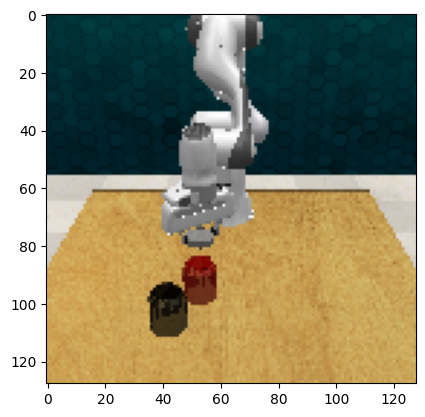

In [104]:
import matplotlib.pyplot as plt
import torchvision
print(data['front_rgb'].shape)
print(data['front_rgb'])
front_rgb = data['front_rgb'].to(torch.int)
plt.imshow(torchvision.utils.make_grid(front_rgb)[0].permute(1,2,0))
# data['front_rgb'].shape

In [96]:

def preprocess_data(data_iter, SILENT=True):
    # try:
    sampled_batch = next(data_iter) # may raise StopIteration
    # print error and restart data iter
    # except Exception as e:
    #     cprint(e, 'red')
    #     # FIXME: this is a pretty bad hack...
    #     cprint("restarting data iter...", 'red')
    #     return self.preprocess_data(data_iter)
    
    batch = {k: v for k, v in sampled_batch.items() if type(v) == torch.Tensor}
    batch['nerf_multi_view_rgb'] = sampled_batch['nerf_multi_view_rgb'] # [bs, 1, 21]
    batch['nerf_multi_view_depth'] = sampled_batch['nerf_multi_view_depth']
    batch['nerf_multi_view_camera'] = sampled_batch['nerf_multi_view_camera'] # must!!!
    batch['lang_goal'] = sampled_batch['lang_goal']

    if 'nerf_next_multi_view_rgb' in sampled_batch:
        batch['nerf_next_multi_view_rgb'] = sampled_batch['nerf_next_multi_view_rgb']
        batch['nerf_next_multi_view_depth'] = sampled_batch['nerf_next_multi_view_depth']
        batch['nerf_next_multi_view_camera'] = sampled_batch['nerf_next_multi_view_camera']
    
    if len(batch['nerf_multi_view_rgb'].shape) == 3:
        batch['nerf_multi_view_rgb'] = batch['nerf_multi_view_rgb'].squeeze(1)
        batch['nerf_multi_view_depth'] = batch['nerf_multi_view_depth'].squeeze(1)
        batch['nerf_multi_view_camera'] = batch['nerf_multi_view_camera'].squeeze(1)

        if 'nerf_next_multi_view_rgb' in batch and batch['nerf_next_multi_view_rgb'] is not None:
            batch['nerf_next_multi_view_rgb'] = batch['nerf_next_multi_view_rgb'].squeeze(1)
            batch['nerf_next_multi_view_depth'] = batch['nerf_next_multi_view_depth'].squeeze(1)
            batch['nerf_next_multi_view_camera'] = batch['nerf_next_multi_view_camera'].squeeze(1)
    
    # print(batch['nerf_multi_view_rgb'])
    if batch['nerf_multi_view_rgb'] is None or batch['nerf_multi_view_rgb'][0,0] is None:
        if not SILENT:
            cprint('batch[nerf_multi_view_rgb] is None. find next data iter', 'red')
        return preprocess_data(data_iter)
    
    return batch

In [106]:
data_iter = iter(dataset)
batch = preprocess_data(data_iter, False)

[['/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/140/images/0.png'
  '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/140/images/1.png'
  '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/140/images/2.png'
  '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/140/images/3.png'
  '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/140/images/4.png'
  '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/140/images/5.png'
  '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/140/images/6.png'
  '/home/bruce/Project/ManiGaussian/data/train_data/close_jar/all_variations/episodes/episode0/nerf_data/140/images/7.png'
  '/home/bruce/P

### qattention_manigaussian_bc_agent

In [ ]:
import logging
import os
from typing import List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from yarr.agents.agent import Agent, ActResult, ScalarSummary, \
    HistogramSummary, ImageSummary, Summary
from termcolor import colored, cprint
import io

from helpers.utils import visualise_voxel
from voxel.voxel_grid import VoxelGrid
from voxel.augmentation import apply_se3_augmentation_with_camera_pose
from helpers.clip.core.clip import build_model, load_clip
import PIL.Image as Image
import transformers
from helpers.optim.lamb import Lamb
from torch.nn.parallel import DistributedDataParallel as DDP
from agents.manigaussian_bc.neural_rendering import NeuralRenderer
from agents.manigaussian_bc.utils import visualize_pcd
from helpers.language_model import create_language_model

import wandb
import visdom
from lightning.fabric import Fabric


NAME = 'QAttentionAgent'


def visualize_feature_map_by_clustering(features, num_cluster=4, return_cluster_center=False):
    from sklearn.cluster import KMeans
    features = features.cpu().detach().numpy()
    B, D, H, W = features.shape
    features_1d = features.reshape(B, D, H*W).transpose(0, 2, 1).reshape(-1, D)
    kmeans = KMeans(n_clusters=num_cluster, random_state=0, n_init=10).fit(features_1d)
    labels = kmeans.labels_
    labels = labels.reshape(H, W)

    cluster_colors = [
        np.array([255, 0, 0]),   # red
        np.array([0, 255, 0]),       # green
        np.array([0, 0, 255]),      # blue
        np.array([255, 255, 0]),   # yellow
        np.array([255, 0, 255]),  # magenta
        np.array([0, 255, 255]),    # cyan
    ]

    segmented_img = np.zeros((H, W, 3))
    for i in range(num_cluster):
        segmented_img[labels==i] = cluster_colors[i]
        
    if return_cluster_center:
        cluster_centers = []
        for i in range(num_cluster):
            cluster_pixels = np.argwhere(labels == i)
            cluster_center = cluster_pixels.mean(axis=0)
            cluster_centers.append(cluster_center)
        return labels, cluster_centers
        
    return segmented_img
 
def visualize_feature_map_by_normalization(features):
    '''
    Normalize feature map to [0, 1] for plt.show()
    :features: (B, 3, H, W)
    Return: (H, W, 3)
    '''
    MIN_DENOMINATOR = 1e-12
    features = features[0].cpu().detach().numpy()
    features = features.transpose(1, 2, 0)  # [H, W, 3]
    features = features / (np.linalg.norm(features, axis=-1, keepdims=True) + MIN_DENOMINATOR)
    return features
 
def PSNR_torch(img1, img2, max_val=1):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_val
    return 20 * torch.log10(PIXEL_MAX / torch.sqrt(mse))


def parse_camera_file(file_path):
    """
    Parse our camera format.

    The format is (*.txt):
    
    4x4 matrix (camera extrinsic)
    space
    3x3 matrix (camera intrinsic)

    focal is extracted from the intrinsc matrix
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()

    camera_extrinsic = []
    for x in lines[0:4]:
        camera_extrinsic += [float(y) for y in x.split()]
    camera_extrinsic = np.array(camera_extrinsic).reshape(4, 4)

    camera_intrinsic = []
    for x in lines[5:8]:
        camera_intrinsic += [float(y) for y in x.split()]
    camera_intrinsic = np.array(camera_intrinsic).reshape(3, 3)

    focal = camera_intrinsic[0, 0]

    return camera_extrinsic, camera_intrinsic, focal

def parse_img_file(file_path, mask_gt_rgb=False, bg_color=[0,0,0,255]):
    """
    return np.array of RGB image with range [0, 1]
    """
    rgb = Image.open(file_path).convert('RGB')
    rgb = np.asarray(rgb).astype(np.float32) / 255.0    # [0, 1]
    return rgb

def parse_depth_file(file_path):
    """
    return np.array of depth image
    """
    depth = Image.open(file_path).convert('L')
    depth = np.asarray(depth).astype(np.float32)
    return depth


class QFunction(nn.Module):

    def __init__(self,
                 perceiver_encoder: nn.Module,
                 voxelizer: VoxelGrid,
                 bounds_offset: float,
                 rotation_resolution: float,
                 device,
                 training,
                 use_ddp=True,  # default: True
                 cfg=None,
                 fabric=None,):
        super(QFunction, self).__init__()
        self._rotation_resolution = rotation_resolution
        self._voxelizer = voxelizer
        self._bounds_offset = bounds_offset
        self._qnet = perceiver_encoder.to(device)
        self._coord_trans = torch.diag(torch.tensor([1, 1, 1, 1], dtype=torch.float32)).to(device)
        
        self.cfg = cfg
        if cfg.use_neural_rendering:
            self._neural_renderer = NeuralRenderer(cfg.neural_renderer).to(device)
            if training and use_ddp:
                self._neural_renderer = fabric.setup(self._neural_renderer)
        else:
            self._neural_renderer = None
        print(colored(f"[NeuralRenderer]: {cfg.use_neural_rendering}", "cyan"))
        
        # distributed training
        if training and use_ddp:
            print(colored(f"[QFunction] use DDP: True", "cyan"))
            self._qnet = fabric.setup(self._qnet)
        
        self.device = device

    def _argmax_3d(self, tensor_orig):
        b, c, d, h, w = tensor_orig.shape  # c will be one
        idxs = tensor_orig.view(b, c, -1).argmax(-1)
        indices = torch.cat([((idxs // h) // d), (idxs // h) % w, idxs % w], 1)
        return indices


    def choose_highest_action(self, q_trans, q_rot_grip, q_collision):
        coords = self._argmax_3d(q_trans)
        rot_and_grip_indicies = None
        ignore_collision = None
        if q_rot_grip is not None:
            q_rot = torch.stack(torch.split(
                q_rot_grip[:, :-2],
                int(360 // self._rotation_resolution),
                dim=1), dim=1)
            rot_and_grip_indicies = torch.cat(
                [q_rot[:, 0:1].argmax(-1),
                 q_rot[:, 1:2].argmax(-1),
                 q_rot[:, 2:3].argmax(-1),
                 q_rot_grip[:, -2:].argmax(-1, keepdim=True)], -1)
            ignore_collision = q_collision[:, -2:].argmax(-1, keepdim=True)
        return coords, rot_and_grip_indicies, ignore_collision
    

    def forward(self, rgb_pcd, depth, proprio, pcd, camera_extrinsics, camera_intrinsics, lang_goal_emb, lang_token_embs,
                bounds=None, prev_bounds=None, prev_layer_voxel_grid=None,
                use_neural_rendering=False, nerf_target_rgb=None, nerf_target_depth=None,
                nerf_target_pose=None, nerf_target_camera_intrinsic=None,
                lang_goal=None,
                nerf_next_target_rgb=None, nerf_next_target_pose=None, nerf_next_target_depth=None,
                nerf_next_target_camera_intrinsic=None,
                gt_embed=None, step=None, action=None):
        '''
        Return Q-functions and neural rendering loss
        '''

        b = rgb_pcd[0][0].shape[0]

        pcd_flat = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(b, -1, 3) for p in pcd], 1)  # [1, 16384, 3]
        
        # flatten RGBs and Pointclouds
        rgb = [rp[0] for rp in rgb_pcd]
        feat_size = rgb[0].shape[1] # 3

        flat_imag_features = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(b, -1, feat_size) for p in rgb], 1)  # [1, 16384, 3]

        # construct voxel grid
        voxel_grid, voxel_density = self._voxelizer.coords_to_bounding_voxel_grid(
            pcd_flat, coord_features=flat_imag_features, coord_bounds=bounds, return_density=True)

        # swap to channels fist
        voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach() # Bx10x100x100x100

        # batch bounds if necessary
        if bounds.shape[0] != b:
            bounds = bounds.repeat(b, 1)

        # forward pass
        q_trans, \
        q_rot_and_grip,\
        q_ignore_collisions,\
        voxel_grid_feature, \
        multi_scale_voxel_list, \
        lang_embedd = self._qnet(voxel_grid,  # [1,10,100^3]
                                proprio, # [1,4]
                                lang_goal_emb, # [1,1024]
                                lang_token_embs, # [1,77,512]
                                None,
                                bounds, # [1,6]
                                None)

        # neural rendering as an auxiliary loss
        rendering_loss_dict = {}
        if use_neural_rendering:    # train default: True; eval default: False
            # prepare nerf rendering
            focal = camera_intrinsics[0][:, 0, 0]  # [SB]
            cx = 128 / 2
            cy = 128 / 2
            c = torch.tensor([cx, cy], dtype=torch.float32).unsqueeze(0)

            if nerf_target_rgb is not None:
                gt_rgb = nerf_target_rgb    # [1,128,128,3]
                gt_pose = nerf_target_pose @ self._coord_trans # remember to do this
                gt_depth = nerf_target_depth

                # We only use the front camera
                rgb_0 = rgb[0]
                depth_0 = depth[0]
                pcd_0 = pcd[0]

                # render loss
                rendering_loss_dict, _ = self._neural_renderer(
                    rgb=rgb_0, pcd=pcd_0, depth=depth_0, \
                    language=lang_embedd, \
                    dec_fts=voxel_grid_feature, \
                    gt_rgb=gt_rgb, gt_depth=gt_depth, \
                    focal=focal, c=c, \
                    gt_pose=gt_pose, gt_intrinsic=nerf_target_camera_intrinsic, \
                    lang_goal=lang_goal, 
                    next_gt_pose=nerf_next_target_pose, next_gt_intrinsic=nerf_next_target_camera_intrinsic, 
                    next_gt_rgb=nerf_next_target_rgb, step=step, action=action,
                    training=True,
                    )

            else:
                # # if we do not have additional multi-view data, we use input view as reconstruction target
                rendering_loss_dict = {
                    'loss': 0.,
                    'loss_rgb': 0.,
                    'loss_embed': 0.,
                    'l1': 0.,
                    'psnr': 0.,
                    }

        return q_trans, q_rot_and_grip, q_ignore_collisions, voxel_grid, rendering_loss_dict


    @torch.no_grad()
    def render(self, rgb_pcd, proprio, pcd, 
               lang_goal_emb, lang_token_embs,
                tgt_pose, tgt_intrinsic,
               camera_extrinsics=None, camera_intrinsics=None,
                depth=None, bounds=None, prev_bounds=None, prev_layer_voxel_grid=None,
                nerf_target_rgb=None, lang_goal=None,
                nerf_next_target_rgb=None, nerf_next_target_depth=None,
                nerf_next_target_pose=None, nerf_next_target_camera_intrinsic=None, 
                action=None, step=None,
                ):
        """
        Render the novel view and the next novel view during the training process
        """
        # rgb_pcd will be list of [rgb, pcd]
        b = rgb_pcd[0][0].shape[0]
        pcd_flat = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(b, -1, 3) for p in pcd], 1)

        # flatten RGBs and Pointclouds
        rgb = [rp[0] for rp in rgb_pcd]
        feat_size = rgb[0].shape[1]
        flat_imag_features = torch.cat(
            [p.permute(0, 2, 3, 1).reshape(b, -1, feat_size) for p in rgb], 1)

        # construct voxel grid
        voxel_grid, voxel_density = self._voxelizer.coords_to_bounding_voxel_grid(
            pcd_flat, coord_features=flat_imag_features, coord_bounds=bounds, return_density=True)

        # swap to channels fist
        voxel_grid = voxel_grid.permute(0, 4, 1, 2, 3).detach()

        # batch bounds if necessary
        if bounds.shape[0] != b:
            bounds = bounds.repeat(b, 1)

        # forward pass
        q_trans, \
        q_rot_and_grip,\
        q_ignore_collisions,\
        voxel_grid_feature,\
        multi_scale_voxel_list,\
        lang_embedd = self._qnet(voxel_grid, 
                                        proprio,
                                        lang_goal_emb, 
                                        lang_token_embs,
                                        prev_layer_voxel_grid,
                                        bounds, 
                                        prev_bounds)

        # prepare nerf rendering
        # We only use the front camera
        _, ret_dict = self._neural_renderer(
                pcd=pcd[0],
                rgb=rgb[0],
                dec_fts=voxel_grid_feature,
                language=lang_embedd,
                gt_pose=tgt_pose,
                gt_intrinsic=tgt_intrinsic,
                # for providing gt embed
                gt_rgb=nerf_target_rgb,
                lang_goal=lang_goal,
                next_gt_rgb=nerf_next_target_rgb,
                next_gt_pose=nerf_next_target_pose,
                next_gt_intrinsic=nerf_next_target_camera_intrinsic,
                step=step,
                action=action,
                training=False,
                )

        return ret_dict.render_novel, ret_dict.next_render_novel, ret_dict.render_embed, ret_dict.gt_embed


class QAttentionPerActBCAgent(Agent):

    def __init__(self,
                 layer: int,
                 coordinate_bounds: list,
                 perceiver_encoder: nn.Module,
                 camera_names: list,
                 batch_size: int,
                 voxel_size: int,
                 bounds_offset: float,
                 voxel_feature_size: int,
                 image_crop_size: int,
                 num_rotation_classes: int,
                 rotation_resolution: float,
                 lr: float = 0.0001,
                 lr_scheduler: bool = False,
                 training_iterations: int = 100000,
                 num_warmup_steps: int = 20000,
                 trans_loss_weight: float = 1.0,
                 rot_loss_weight: float = 1.0,
                 grip_loss_weight: float = 1.0,
                 collision_loss_weight: float = 1.0,
                 include_low_dim_state: bool = False,
                 image_resolution: list = None,
                 lambda_weight_l2: float = 0.0,
                 transform_augmentation: bool = True,   # True
                 transform_augmentation_xyz: list = [0.0, 0.0, 0.0],
                 transform_augmentation_rpy: list = [0.0, 0.0, 180.0],
                 transform_augmentation_rot_resolution: int = 5,
                 optimizer_type: str = 'adam',
                 num_devices: int = 1,
                 cfg = None,
                 ):
        self._layer = layer
        self._coordinate_bounds = coordinate_bounds
        self._perceiver_encoder = perceiver_encoder
        self._voxel_feature_size = voxel_feature_size
        self._bounds_offset = bounds_offset
        self._image_crop_size = image_crop_size
        self._lr = lr
        self._lr_scheduler = lr_scheduler
        self._training_iterations = training_iterations
        self._num_warmup_steps = num_warmup_steps
        self._trans_loss_weight = trans_loss_weight
        self._rot_loss_weight = rot_loss_weight
        self._grip_loss_weight = grip_loss_weight
        self._collision_loss_weight = collision_loss_weight
        self._include_low_dim_state = include_low_dim_state
        self._image_resolution = image_resolution or [128, 128]
        self._voxel_size = voxel_size
        self._camera_names = camera_names
        self._num_cameras = len(camera_names)
        self._batch_size = batch_size
        self._lambda_weight_l2 = lambda_weight_l2
        self._transform_augmentation = transform_augmentation
        self._transform_augmentation_xyz = torch.from_numpy(np.array(transform_augmentation_xyz))
        self._transform_augmentation_rpy = transform_augmentation_rpy
        self._transform_augmentation_rot_resolution = transform_augmentation_rot_resolution
        self._optimizer_type = optimizer_type
        self._num_devices = num_devices
        self._num_rotation_classes = num_rotation_classes
        self._rotation_resolution = rotation_resolution

        self.cfg = cfg
        
        self.use_neural_rendering = self.cfg.use_neural_rendering
        print(colored(f"use_neural_rendering: {self.use_neural_rendering}", "red"))

        if self.use_neural_rendering:
            print(colored(f"[agent] nerf weight step: {self.cfg.neural_renderer.lambda_nerf}", "red"))

        self._cross_entropy_loss = nn.CrossEntropyLoss(reduction='mean')  # if batch size>1
        
        self._mask_gt_rgb = cfg.neural_renderer.dataset.mask_gt_rgb
        print(colored(f"[NeuralRenderer] mask_gt_rgb: {self._mask_gt_rgb}", "cyan"))
        
        self._name = NAME + '_layer' + str(self._layer)

    def build(self, training: bool, device: torch.device = None, use_ddp=True, fabric: Fabric = None):
        self._training = training
        self._device = device

        if device is None:
            device = torch.device('cpu')

        print(f"device: {device}")
        self._voxelizer = VoxelGrid(
            coord_bounds=self._coordinate_bounds.cpu() if isinstance(self._coordinate_bounds, torch.Tensor) else self._coordinate_bounds,
            voxel_size=self._voxel_size,
            device=device,  # 0
            batch_size=self._batch_size if training else 1,
            feature_size=self._voxel_feature_size,
            max_num_coords=np.prod(self._image_resolution) * self._num_cameras,
        )

        self._q = QFunction(self._perceiver_encoder,
                            self._voxelizer,
                            self._bounds_offset,
                            self._rotation_resolution,
                            device,
                            training,
                            use_ddp,
                            self.cfg,
                            fabric=fabric).to(device).train(training)

        grid_for_crop = torch.arange(0,
                                     self._image_crop_size,
                                     device=device).unsqueeze(0).repeat(self._image_crop_size, 1).unsqueeze(-1)
        self._grid_for_crop = torch.cat([grid_for_crop.transpose(1, 0),
                                         grid_for_crop], dim=2).unsqueeze(0)

        self._coordinate_bounds = torch.tensor(self._coordinate_bounds,
                                               device=device).unsqueeze(0)

        if self._training:
            # optimizer
            if self._optimizer_type == 'lamb':
                self._optimizer = Lamb(
                    self._q.parameters(),
                    lr=self._lr,
                    weight_decay=self._lambda_weight_l2,
                    betas=(0.9, 0.999),
                    adam=False,
                )
            elif self._optimizer_type == 'adam':
                self._optimizer = torch.optim.Adam(
                    self._q.parameters(),
                    lr=self._lr,
                    weight_decay=self._lambda_weight_l2,
                )
            else:
                raise Exception('Unknown optimizer type')
            
            # DDP optimizer
            self._optimizer = fabric.setup_optimizers(self._optimizer)

            # learning rate scheduler
            if self._lr_scheduler:
                self._scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
                    self._optimizer,
                    num_warmup_steps=self._num_warmup_steps,
                    num_training_steps=self._training_iterations,
                    num_cycles=self._training_iterations // 10000,
                )

            # one-hot zero tensors
            self._action_trans_one_hot_zeros = torch.zeros((self._batch_size,
                                                            1,
                                                            self._voxel_size,
                                                            self._voxel_size,
                                                            self._voxel_size),
                                                            dtype=int,
                                                            device=device)
            self._action_rot_x_one_hot_zeros = torch.zeros((self._batch_size,
                                                            self._num_rotation_classes),
                                                            dtype=int,
                                                            device=device)
            self._action_rot_y_one_hot_zeros = torch.zeros((self._batch_size,
                                                            self._num_rotation_classes),
                                                            dtype=int,
                                                            device=device)
            self._action_rot_z_one_hot_zeros = torch.zeros((self._batch_size,
                                                            self._num_rotation_classes),
                                                            dtype=int,
                                                            device=device)
            self._action_grip_one_hot_zeros = torch.zeros((self._batch_size,
                                                           2),
                                                           dtype=int,
                                                           device=device)
            self._action_ignore_collisions_one_hot_zeros = torch.zeros((self._batch_size,
                                                                        2),
                                                                        dtype=int,
                                                                        device=device)

            # print total params
            logging.info('# Q Params: %d M' % (sum(
                p.numel() for name, p in self._q.named_parameters() \
                if p.requires_grad and 'clip' not in name)/1e6) )
        else:
            for param in self._q.parameters():
                param.requires_grad = False

            self.language_model =  create_language_model(self.cfg.language_model)
            self._voxelizer.to(device)
            self._q.to(device)

    def _preprocess_inputs(self, replay_sample, sample_id=None):
        obs = []
        depths = []
        pcds = []
        exs = []
        ins = []
        self._crop_summary = []
        for n in self._camera_names:    # default: [front,left_shoulder,right_shoulder,wrist] or [front]
            if sample_id is not None:   # default: None
                rgb = replay_sample['%s_rgb' % n][sample_id:sample_id+1]
                depth = replay_sample['%s_depth' % n][sample_id:sample_id+1]
                pcd = replay_sample['%s_point_cloud' % n][sample_id:sample_id+1]
                extin = replay_sample['%s_camera_extrinsics' % n][sample_id:sample_id+1]
                intin = replay_sample['%s_camera_intrinsics' % n][sample_id:sample_id+1]
            else:
                rgb = replay_sample['%s_rgb' % n]
                depth = replay_sample['%s_depth' % n]
                pcd = replay_sample['%s_point_cloud' % n]
                extin = replay_sample['%s_camera_extrinsics' % n]
                intin = replay_sample['%s_camera_intrinsics' % n]
            obs.append([rgb, pcd])
            depths.append(depth)
            pcds.append(pcd)
            exs.append(extin)
            ins.append(intin)
        return obs, depths, pcds, exs, ins

    def _act_preprocess_inputs(self, observation):
        obs, depths, pcds, exs, ins = [], [], [], [], []
        for n in self._camera_names:
            rgb = observation['%s_rgb' % n]
            # [-1,1] to [0,1]
            # rgb = (rgb + 1) / 2
            depth = observation['%s_depth' % n]
            pcd = observation['%s_point_cloud' % n]
            extin = observation['%s_camera_extrinsics' % n].squeeze(0)
            intin = observation['%s_camera_intrinsics' % n].squeeze(0)

            obs.append([rgb, pcd])
            depths.append(depth)
            pcds.append(pcd)
            exs.append(extin)
            ins. append(intin)
        return obs, depths, pcds, exs, ins

    def _get_value_from_voxel_index(self, q, voxel_idx):
        b, c, d, h, w = q.shape
        q_trans_flat = q.view(b, c, d * h * w)
        flat_indicies = (voxel_idx[:, 0] * d * h + voxel_idx[:, 1] * h + voxel_idx[:, 2])[:, None].int()
        highest_idxs = flat_indicies.unsqueeze(-1).repeat(1, c, 1)
        chosen_voxel_values = q_trans_flat.gather(2, highest_idxs)[..., 0]  # (B, trans + rot + grip)
        return chosen_voxel_values

    def _get_value_from_rot_and_grip(self, rot_grip_q, rot_and_grip_idx):
        q_rot = torch.stack(torch.split(
            rot_grip_q[:, :-2], int(360 // self._rotation_resolution),
            dim=1), dim=1)  # B, 3, 72
        q_grip = rot_grip_q[:, -2:]
        rot_and_grip_values = torch.cat(
            [q_rot[:, 0].gather(1, rot_and_grip_idx[:, 0:1]),
             q_rot[:, 1].gather(1, rot_and_grip_idx[:, 1:2]),
             q_rot[:, 2].gather(1, rot_and_grip_idx[:, 2:3]),
             q_grip.gather(1, rot_and_grip_idx[:, 3:4])], -1)
        return rot_and_grip_values

    def _celoss(self, pred, labels):
        return self._cross_entropy_loss(pred, labels.argmax(-1))

    def _softmax_q_trans(self, q):
        q_shape = q.shape
        return F.softmax(q.reshape(q_shape[0], -1), dim=1).reshape(q_shape)

    def _softmax_q_rot_grip(self, q_rot_grip):
        q_rot_x_flat = q_rot_grip[:, 0*self._num_rotation_classes: 1*self._num_rotation_classes]
        q_rot_y_flat = q_rot_grip[:, 1*self._num_rotation_classes: 2*self._num_rotation_classes]
        q_rot_z_flat = q_rot_grip[:, 2*self._num_rotation_classes: 3*self._num_rotation_classes]
        q_grip_flat  = q_rot_grip[:, 3*self._num_rotation_classes:]

        q_rot_x_flat_softmax = F.softmax(q_rot_x_flat, dim=1)
        q_rot_y_flat_softmax = F.softmax(q_rot_y_flat, dim=1)
        q_rot_z_flat_softmax = F.softmax(q_rot_z_flat, dim=1)
        q_grip_flat_softmax = F.softmax(q_grip_flat, dim=1)

        return torch.cat([q_rot_x_flat_softmax,
                          q_rot_y_flat_softmax,
                          q_rot_z_flat_softmax,
                          q_grip_flat_softmax], dim=1)

    def _softmax_ignore_collision(self, q_collision):
        q_collision_softmax = F.softmax(q_collision, dim=1)
        return q_collision_softmax

    def save_gradient(self, module, grad_input, grad_output):
        """
        for grad-cam
        """
        self.gradient = grad_output[0]

    def save_feature(self, module, input, output):
        """
        for grad-cam
        """
        if isinstance(output, tuple):
            self.feature = output[0].detach()
        else:
            self.feature = output.detach()
            
        
    def update(self, step: int, replay_sample: dict, fabric: Fabric) -> dict:
        '''
        : replay_sample.action: [bs, 8]
        : replay_sample['trans_action_indicies']: [bs, 3]
        '''
        action_gt = replay_sample['action'] # [bs, 8]
        action_trans = replay_sample['trans_action_indicies'][:, self._layer * 3:self._layer * 3 + 3].int()
        action_rot_grip = replay_sample['rot_grip_action_indicies'].int()
        action_gripper_pose = replay_sample['gripper_pose']
        action_ignore_collisions = replay_sample['ignore_collisions'].int()
        lang_goal_emb = replay_sample['lang_goal_emb'].float()
        lang_token_embs = replay_sample['lang_token_embs'].float()
        prev_layer_voxel_grid = replay_sample.get('prev_layer_voxel_grid', None)
        prev_layer_bounds = replay_sample.get('prev_layer_bounds', None)
        lang_goal = replay_sample['lang_goal']

        device = self._device

        # get rank by device id
        rank = self._q.device

        obs, depth, pcd, extrinsics, intrinsics = self._preprocess_inputs(replay_sample)
        # batch size
        bs = pcd[0].shape[0]

        # for nerf multi-view training
        nerf_multi_view_rgb_path = replay_sample['nerf_multi_view_rgb'] # only succeed to get path sometime
        nerf_multi_view_depth_path = replay_sample['nerf_multi_view_depth']
        nerf_multi_view_camera_path = replay_sample['nerf_multi_view_camera']

        nerf_next_multi_view_rgb_path = replay_sample['nerf_next_multi_view_rgb']
        nerf_next_multi_view_depth_path = replay_sample['nerf_next_multi_view_depth']
        nerf_next_multi_view_camera_path = replay_sample['nerf_next_multi_view_camera']

        # cprint(nerf_multi_view_rgb_path, 'red')

        if nerf_multi_view_rgb_path is None or nerf_multi_view_rgb_path[0,0] is None:
            cprint(nerf_multi_view_rgb_path, 'red')
            cprint(replay_sample['indices'], 'red')
            nerf_target_rgb = None
            nerf_target_camera_extrinsic = None
            print(colored('warn: one iter not use additional multi view', 'cyan'))
            raise ValueError('nerf_multi_view_rgb_path is None')
        else:
            # control the number of views by the following code
            num_view = nerf_multi_view_rgb_path.shape[-1]
            num_view_by_user = self.cfg.num_view_for_nerf
            # compute interval first
            assert num_view_by_user <= num_view, f'num_view_by_user {num_view_by_user} should be less than num_view {num_view}'
            interval = num_view // num_view_by_user # 21//20?
            nerf_multi_view_rgb_path = nerf_multi_view_rgb_path[:, ::interval]
            
            # sample one target img
            view_dix = np.random.randint(0, num_view_by_user)
            nerf_multi_view_rgb_path = nerf_multi_view_rgb_path[:, view_dix]
            nerf_multi_view_depth_path = nerf_multi_view_depth_path[:, view_dix]
            nerf_multi_view_camera_path = nerf_multi_view_camera_path[:, view_dix]

            next_view_dix = np.random.randint(0, num_view_by_user)
            nerf_next_multi_view_rgb_path = nerf_next_multi_view_rgb_path[:, next_view_dix]
            nerf_next_multi_view_depth_path = nerf_next_multi_view_depth_path[:, next_view_dix]
            nerf_next_multi_view_camera_path = nerf_next_multi_view_camera_path[:, next_view_dix]

            # load img and camera (support bs>1)
            nerf_target_rgbs, nerf_target_depths, nerf_target_camera_extrinsics, nerf_target_camera_intrinsics = [], [], [], []
            nerf_next_target_rgbs, nerf_next_target_depths, nerf_next_target_camera_extrinsics, nerf_next_target_camera_intrinsics = [], [], [], []
            for i in range(bs):
                nerf_target_rgbs.append(parse_img_file(nerf_multi_view_rgb_path[i], mask_gt_rgb=self._mask_gt_rgb))#, session=self._rembg_session))    # FIXME: file_path 'NoneType' object has no attribute 'read'
                nerf_target_depths.append(parse_depth_file(nerf_multi_view_depth_path[i]))
                nerf_target_camera_extrinsic, nerf_target_camera_intrinsic, nerf_target_focal = parse_camera_file(nerf_multi_view_camera_path[i])
                nerf_target_camera_extrinsics.append(nerf_target_camera_extrinsic)
                nerf_target_camera_intrinsics.append(nerf_target_camera_intrinsic)

                nerf_next_target_rgbs.append(parse_img_file(nerf_next_multi_view_rgb_path[i], mask_gt_rgb=self._mask_gt_rgb))#, session=self._rembg_session))    # FIXME: file_path 'NoneType' object has no attribute 'read'
                nerf_next_target_depths.append(parse_depth_file(nerf_next_multi_view_depth_path[i]))
                nerf_next_target_camera_extrinsic, nerf_next_target_camera_intrinsic, nerf_next_target_focal = parse_camera_file(nerf_next_multi_view_camera_path[i])
                nerf_next_target_camera_extrinsics.append(nerf_next_target_camera_extrinsic)
                nerf_next_target_camera_intrinsics.append(nerf_next_target_camera_intrinsic)

            nerf_target_rgb = torch.from_numpy(np.stack(nerf_target_rgbs)).float().to(device) # [bs, H, W, 3], [0,1]
            nerf_target_depth = torch.from_numpy(np.stack(nerf_target_depths)).float().to(device) # [bs, H, W, 1], no normalization
            nerf_target_camera_extrinsic = torch.from_numpy(np.stack(nerf_target_camera_extrinsics)).float().to(device)
            nerf_target_camera_intrinsic = torch.from_numpy(np.stack(nerf_target_camera_intrinsics)).float().to(device)

            nerf_next_target_rgb = torch.from_numpy(np.stack(nerf_next_target_rgbs)).float().to(device) # [bs, H, W, 3], [0,1]
            nerf_next_target_depth = torch.from_numpy(np.stack(nerf_next_target_depths)).float().to(device) # [bs, H, W, 1], no normalization
            nerf_next_target_camera_extrinsic = torch.from_numpy(np.stack(nerf_next_target_camera_extrinsics)).float().to(device)
            nerf_next_target_camera_intrinsic = torch.from_numpy(np.stack(nerf_next_target_camera_intrinsics)).float().to(device)

        bounds = self._coordinate_bounds.to(device)
        if self._layer > 0:
            cp = replay_sample['attention_coordinate_layer_%d' % (self._layer - 1)]
            bounds = torch.cat([cp - self._bounds_offset, cp + self._bounds_offset], dim=1)

        proprio = None
        if self._include_low_dim_state:
            proprio = replay_sample['low_dim_state']

        # SE(3) augmentation of point clouds and actions
        if self._transform_augmentation:    # default: True
            action_trans, \
            action_rot_grip, \
            pcd,\
            extrinsics = apply_se3_augmentation_with_camera_pose(pcd,
                                         extrinsics,
                                         action_gripper_pose,
                                         action_trans,
                                         action_rot_grip,
                                         bounds,
                                         self._layer,
                                         self._transform_augmentation_xyz,
                                         self._transform_augmentation_rpy,
                                         self._transform_augmentation_rot_resolution,
                                         self._voxel_size,
                                         self._rotation_resolution,
                                         self._device)

        # forward pass
        q_trans, q_rot_grip, \
        q_collision, \
        voxel_grid, \
        rendering_loss_dict = self._q(obs,
                                depth,
                                proprio,
                                pcd,
                                extrinsics, # although augmented, not used
                                intrinsics,
                                lang_goal_emb,
                                lang_token_embs,
                                bounds,
                                prev_layer_bounds,
                                prev_layer_voxel_grid,
                                use_neural_rendering=self.use_neural_rendering,
                                nerf_target_rgb=nerf_target_rgb,
                                nerf_target_depth=nerf_target_depth,
                                nerf_target_pose=nerf_target_camera_extrinsic,
                                nerf_target_camera_intrinsic=nerf_target_camera_intrinsic,
                                lang_goal=lang_goal,
                                nerf_next_target_rgb=nerf_next_target_rgb,
                                nerf_next_target_depth=nerf_next_target_depth,
                                nerf_next_target_pose=nerf_next_target_camera_extrinsic,
                                nerf_next_target_camera_intrinsic=nerf_next_target_camera_intrinsic,
                                step=step,
                                action=action_gt,
                                )
        # argmax to choose best action
        coords, \
        rot_and_grip_indicies, \
        ignore_collision_indicies = self._q.choose_highest_action(q_trans, q_rot_grip, q_collision)

        q_trans_loss, q_rot_loss, q_grip_loss, q_collision_loss = 0., 0., 0., 0.

        # translation one-hot
        action_trans_one_hot = self._action_trans_one_hot_zeros.clone()
        # action_trans: [bs, 3]
        for b in range(bs):
            gt_coord = action_trans[b, :].int()
            action_trans_one_hot[b, :, gt_coord[0], gt_coord[1], gt_coord[2]] = 1
            
        # translation loss
        q_trans_flat = q_trans.view(bs, -1)
        action_trans_one_hot_flat = action_trans_one_hot.view(bs, -1)   # [1,1,100,100,100]
        q_trans_loss = self._celoss(q_trans_flat, action_trans_one_hot_flat)

        with_rot_and_grip = rot_and_grip_indicies is not None
        if with_rot_and_grip:
            # rotation, gripper, and collision one-hots
            action_rot_x_one_hot = self._action_rot_x_one_hot_zeros.clone()
            action_rot_y_one_hot = self._action_rot_y_one_hot_zeros.clone()
            action_rot_z_one_hot = self._action_rot_z_one_hot_zeros.clone()
            action_grip_one_hot = self._action_grip_one_hot_zeros.clone()
            action_ignore_collisions_one_hot = self._action_ignore_collisions_one_hot_zeros.clone()

            for b in range(bs):
                gt_rot_grip = action_rot_grip[b, :].int()
                action_rot_x_one_hot[b, gt_rot_grip[0]] = 1
                action_rot_y_one_hot[b, gt_rot_grip[1]] = 1
                action_rot_z_one_hot[b, gt_rot_grip[2]] = 1
                action_grip_one_hot[b, gt_rot_grip[3]] = 1

                gt_ignore_collisions = action_ignore_collisions[b, :].int()
                action_ignore_collisions_one_hot[b, gt_ignore_collisions[0]] = 1

            # flatten predictions
            q_rot_x_flat = q_rot_grip[:, 0*self._num_rotation_classes:1*self._num_rotation_classes]
            q_rot_y_flat = q_rot_grip[:, 1*self._num_rotation_classes:2*self._num_rotation_classes]
            q_rot_z_flat = q_rot_grip[:, 2*self._num_rotation_classes:3*self._num_rotation_classes]
            q_grip_flat =  q_rot_grip[:, 3*self._num_rotation_classes:]
            q_ignore_collisions_flat = q_collision

            # rotation loss
            q_rot_loss += self._celoss(q_rot_x_flat, action_rot_x_one_hot)
            q_rot_loss += self._celoss(q_rot_y_flat, action_rot_y_one_hot)
            q_rot_loss += self._celoss(q_rot_z_flat, action_rot_z_one_hot)

            # gripper loss
            q_grip_loss += self._celoss(q_grip_flat, action_grip_one_hot)

            # collision loss
            q_collision_loss += self._celoss(q_ignore_collisions_flat, action_ignore_collisions_one_hot)

        combined_losses = (q_trans_loss * self._trans_loss_weight) + \
                          (q_rot_loss * self._rot_loss_weight) + \
                          (q_grip_loss * self._grip_loss_weight) + \
                          (q_collision_loss * self._collision_loss_weight)
        total_loss = combined_losses.mean()

        if self.use_neural_rendering:   # eval default: False; train default: True
            
            lambda_nerf = self.cfg.neural_renderer.lambda_nerf
            lambda_BC = self.cfg.lambda_bc

            total_loss = lambda_BC * total_loss + lambda_nerf * rendering_loss_dict['loss']

            # for print
            loss_rgb_item = rendering_loss_dict['loss_rgb']
            loss_embed_item = rendering_loss_dict['loss_embed']
            loss_dyna_item = rendering_loss_dict['loss_dyna']
            loss_reg_item = rendering_loss_dict['loss_reg']
            psnr = rendering_loss_dict['psnr']

            lambda_embed = self.cfg.neural_renderer.lambda_embed * lambda_nerf  # 0.0001
            lambda_rgb = self.cfg.neural_renderer.lambda_rgb * lambda_nerf  # 0.01
            lambda_dyna = (self.cfg.neural_renderer.lambda_dyna if step >= self.cfg.neural_renderer.next_mlp.warm_up else 0.) * lambda_nerf  # 0.01
            lambda_reg = (self.cfg.neural_renderer.lambda_reg if step >= self.cfg.neural_renderer.next_mlp.warm_up else 0.) * lambda_nerf  # 0.01

            if step % 10 == 0 and rank == 0:
                cprint(f'total L: {total_loss.item():.4f} | \
L_BC: {combined_losses.item():.3f} x {lambda_BC:.3f} | \
L_trans: {q_trans_loss.item():.3f} x {(self._trans_loss_weight * lambda_BC):.3f} | \
L_rot: {q_rot_loss.item():.3f} x {(self._rot_loss_weight * lambda_BC):.3f} | \
L_grip: {q_grip_loss.item():.3f} x {(self._grip_loss_weight * lambda_BC):.3f} | \
L_col: {q_collision_loss.item():.3f} x {(self._collision_loss_weight * lambda_BC):.3f} | \
L_rgb: {loss_rgb_item:.3f} x {lambda_rgb:.3f} | \
L_embed: {loss_embed_item:.3f} x {lambda_embed:.4f} | \
L_dyna: {loss_dyna_item:.3f} x {lambda_dyna:.4f} | \
L_reg: {loss_reg_item:.3f} x {lambda_reg:.4f} | \
psnr: {psnr:.3f}', 'green')

                if self.cfg.use_wandb:
                    wandb.log({
                        'train/BC_loss':combined_losses.item(), 
                        'train/psnr':psnr, 
                        'train/rgb_loss':loss_rgb_item,
                        'train/embed_loss':loss_embed_item,
                        'train/dyna_loss':loss_dyna_item,
                        }, step=step)
            
        else:   # no neural renderer
            if step % 10 == 0 and rank == 0:
                lambda_BC = self.cfg.lambda_bc
                cprint(f'total L: {total_loss.item():.4f} | \
L_BC: {combined_losses.item():.3f} x {lambda_BC:.3f} | \
L_trans: {q_trans_loss.item():.3f} x {(self._trans_loss_weight * lambda_BC):.3f} | \
L_rot: {q_rot_loss.item():.3f} x {(self._rot_loss_weight * lambda_BC):.3f} | \
L_grip: {q_grip_loss.item():.3f} x {(self._grip_loss_weight * lambda_BC):.3f} | \
L_col: {q_collision_loss.item():.3f} x {(self._collision_loss_weight * lambda_BC):.3f}', 'green')
            
                if self.cfg.use_wandb:
                    wandb.log({
                        'train/BC_loss':combined_losses.item(), 
                        }, step=step)

        self._optimizer.zero_grad()
        # total_loss.backward()
        # use fabric ddp
        fabric.backward(total_loss)
        self._optimizer.step()

        ############### Render in training process #################

        render_freq = self.cfg.neural_renderer.render_freq
        to_render = (step % render_freq == 0 and self.use_neural_rendering and nerf_target_camera_extrinsic is not None)
        if to_render:
            rgb_render, next_rgb_render, embed_render, gt_embed_render = self._q.render(
                rgb_pcd=obs,
                proprio=proprio,
                pcd=pcd,
                lang_goal_emb=lang_goal_emb,
                lang_token_embs=lang_token_embs,
                bounds=bounds,
                prev_bounds=prev_layer_bounds,
                prev_layer_voxel_grid=prev_layer_voxel_grid,
                tgt_pose=nerf_target_camera_extrinsic,
                tgt_intrinsic=nerf_target_camera_intrinsic,
                nerf_target_rgb=nerf_target_rgb,
                lang_goal=lang_goal,
                nerf_next_target_rgb=nerf_next_target_rgb,
                nerf_next_target_depth=nerf_next_target_depth,
                nerf_next_target_pose=nerf_next_target_camera_extrinsic,
                nerf_next_target_camera_intrinsic=nerf_next_target_camera_intrinsic,
                step=step,
                action=action_gt,
                )
            
            # NOTE: [1, h, w, 3]
            rgb_gt = nerf_target_rgb[0]
            rgb_render = rgb_render[0]
            psnr = PSNR_torch(rgb_render, rgb_gt)
            if next_rgb_render is not None:
                next_rgb_gt = nerf_next_target_rgb[0]
                next_rgb_render = next_rgb_render[0]
                psnr_dyna = PSNR_torch(next_rgb_render, next_rgb_gt)

            os.makedirs('recon', exist_ok=True)
            import matplotlib.pyplot as plt
            # plot three images in one row with subplots:
            # src, tgt, pred
            rgb_src =  obs[0][0].squeeze(0).permute(1, 2, 0)  / 2 + 0.5
            fig, axs = plt.subplots(1, 7, figsize=(15, 3))
            # src
            axs[0].imshow(rgb_src.cpu().numpy())
            axs[0].title.set_text('src')
            # tgt
            axs[1].imshow(rgb_gt.cpu().numpy())
            axs[1].title.set_text('tgt')
            # pred rgb
            axs[2].imshow(rgb_render.cpu().numpy())
            axs[2].title.set_text('psnr={:.2f}'.format(psnr))
            # pred embed
            # embed_render = visualize_feature_map_by_clustering(embed_render.permute(0,3,1,2), num_cluster=4)
            embed_render = visualize_feature_map_by_normalization(embed_render.permute(0,3,1,2))    # range from -1 to 1
            axs[3].imshow(embed_render)
            axs[3].title.set_text('embed seg')
            # gt embed
            if gt_embed_render is not None:
                # gt_embed_render = visualize_feature_map_by_clustering(gt_embed_render, num_cluster=4)
                gt_embed_render = visualize_feature_map_by_normalization(gt_embed_render)    # range from -1 to 1
                axs[4].imshow(gt_embed_render)
                axs[4].title.set_text('gt embed seg')
            if next_rgb_render is not None:
                # gt next rgb frame
                axs[6].imshow(next_rgb_gt.cpu().numpy())
                axs[6].title.set_text('next tgt')
                # Ours
                axs[5].imshow(next_rgb_render.cpu().numpy())
                axs[5].title.set_text('next psnr={:.2f}'.format(psnr_dyna))
            # remove axis
            for ax in axs:
                ax.axis('off')
            plt.tight_layout()
            
            if rank == 0:
                if self.cfg.use_wandb:
                    # save to buffer and write to wandb
                    buf = io.BytesIO()
                    plt.savefig(buf, format='png')
                    buf.seek(0)

                    image = Image.open(buf)
                    wandb.log({"eval/recon_img": wandb.Image(image)}, step=step)

                    buf.close()
                    workdir = os.getcwd()
                    cprint(f'Saved {workdir}/recon/{step}_rgb.png to wandb', 'cyan')
                else:
                    plt.savefig(f'recon/{step}_rgb.png')
                    workdir = os.getcwd()
                    cprint(f'Saved {workdir}/recon/{step}_rgb.png locally', 'cyan')


        self._summaries = {
            'losses/total_loss': total_loss.item(),
            'losses/trans_loss': q_trans_loss.mean(),
            'losses/rot_loss': q_rot_loss.mean() if with_rot_and_grip else 0.,
            'losses/grip_loss': q_grip_loss.mean() if with_rot_and_grip else 0.,
            'losses/collision_loss': q_collision_loss.mean() if with_rot_and_grip else 0.,
        }

        self._wandb_summaries = {
            'losses/total_loss': total_loss.item(),
            'losses/trans_loss': q_trans_loss.mean(),
            'losses/rot_loss': q_rot_loss.mean() if with_rot_and_grip else 0.,
            'losses/grip_loss': q_grip_loss.mean() if with_rot_and_grip else 0.,
            'losses/collision_loss': q_collision_loss.mean() if with_rot_and_grip else 0.,

            # for visualization
            'point_cloud': None,
            'coord_pred': coords,
            'coord_gt': gt_coord,
        }

        if self._lr_scheduler:
            self._scheduler.step()
            self._summaries['learning_rate'] = self._scheduler.get_last_lr()[0]

        self._vis_voxel_grid = voxel_grid[0]        
        
        self._vis_translation_qvalue = self._softmax_q_trans(q_trans[0])
        self._vis_max_coordinate = coords[0]
        self._vis_gt_coordinate = action_trans[0]

        # Note: PerAct doesn't use multi-layer voxel grids like C2FARM
        # stack prev_layer_voxel_grid(s) from previous layers into a list
        if prev_layer_voxel_grid is None:
            prev_layer_voxel_grid = [voxel_grid]
        else:
            prev_layer_voxel_grid = prev_layer_voxel_grid + [voxel_grid]

        # stack prev_layer_bound(s) from previous layers into a list
        if prev_layer_bounds is None:
            prev_layer_bounds = [self._coordinate_bounds.repeat(bs, 1)]
        else:
            prev_layer_bounds = prev_layer_bounds + [bounds]

        return {
            'total_loss': total_loss,
            'prev_layer_voxel_grid': prev_layer_voxel_grid,
            'prev_layer_bounds': prev_layer_bounds,
        }

    def act(self, step: int, observation: dict,
            deterministic=False) -> ActResult:
        deterministic = True
        bounds = self._coordinate_bounds
        prev_layer_voxel_grid = observation.get('prev_layer_voxel_grid', None)
        prev_layer_bounds = observation.get('prev_layer_bounds', None)
        lang_goal_tokens = observation.get('lang_goal_tokens', None).long()
        lang_goal = observation['lang_goal']

        # extract language embs
        with torch.no_grad():
            lang_goal_emb, lang_token_embs = self.language_model.extract(lang_goal)

        # voxelization resolution
        res = (bounds[:, 3:] - bounds[:, :3]) / self._voxel_size
        max_rot_index = int(360 // self._rotation_resolution)
        proprio = None

        if self._include_low_dim_state:
            proprio = observation['low_dim_state']

        obs, depth, pcd, extrinsics, intrinsics = self._act_preprocess_inputs(observation)

        # correct batch size and device
        obs = [[o[0][0].to(self._device), o[1][0].to(self._device)] for o in obs]
        proprio = proprio[0].to(self._device)
        pcd = [p[0].to(self._device) for p in pcd]
        lang_goal_emb = lang_goal_emb.to(self._device)
        lang_token_embs = lang_token_embs.to(self._device)
        bounds = torch.as_tensor(bounds, device=self._device)
        prev_layer_voxel_grid = prev_layer_voxel_grid.to(self._device) if prev_layer_voxel_grid is not None else None
        prev_layer_bounds = prev_layer_bounds.to(self._device) if prev_layer_bounds is not None else None

        # inference
        q_trans, \
        q_rot_grip, \
        q_ignore_collisions, \
        vox_grid,\
        rendering_loss_dict  = self._q(obs,
                            depth,
                            proprio,
                            pcd,
                            extrinsics,
                            intrinsics,
                            lang_goal_emb,
                            lang_token_embs,
                            bounds,
                            prev_layer_bounds,
                            prev_layer_voxel_grid, 
                            use_neural_rendering=False)

        # softmax Q predictions
        q_trans = self._softmax_q_trans(q_trans)
        q_rot_grip =  self._softmax_q_rot_grip(q_rot_grip) if q_rot_grip is not None else q_rot_grip
        q_ignore_collisions = self._softmax_ignore_collision(q_ignore_collisions) \
            if q_ignore_collisions is not None else q_ignore_collisions

        # argmax Q predictions
        coords, \
        rot_and_grip_indicies, \
        ignore_collisions = self._q.choose_highest_action(q_trans, q_rot_grip, q_ignore_collisions)

        rot_grip_action = rot_and_grip_indicies if q_rot_grip is not None else None
        ignore_collisions_action = ignore_collisions.int() if ignore_collisions is not None else None

        coords = coords.int()
        attention_coordinate = bounds[:, :3] + res * coords + res / 2

        # stack prev_layer_voxel_grid(s) into a list
        # NOTE: PerAct doesn't used multi-layer voxel grids like C2FARM
        if prev_layer_voxel_grid is None:
            prev_layer_voxel_grid = [vox_grid]
        else:
            prev_layer_voxel_grid = prev_layer_voxel_grid + [vox_grid]

        if prev_layer_bounds is None:
            prev_layer_bounds = [bounds]
        else:
            prev_layer_bounds = prev_layer_bounds + [bounds]

        observation_elements = {
            'attention_coordinate': attention_coordinate,
            'prev_layer_voxel_grid': prev_layer_voxel_grid,
            'prev_layer_bounds': prev_layer_bounds,
        }
        info = {
            'voxel_grid_depth%d' % self._layer: vox_grid,
            'q_depth%d' % self._layer: q_trans,
            'voxel_idx_depth%d' % self._layer: coords
        }
        self._act_voxel_grid = vox_grid[0]
        self._act_max_coordinate = coords[0]
        self._act_qvalues = q_trans[0].detach()
        return ActResult((coords, rot_grip_action, ignore_collisions_action),
                         observation_elements=observation_elements,
                         info=info)

    def update_summaries(self) -> List[Summary]:
        summaries = []

        for n, v in self._summaries.items():
            summaries.append(ScalarSummary('%s/%s' % (self._name, n), v))

        for (name, crop) in (self._crop_summary):
            crops = (torch.cat(torch.split(crop, 3, dim=1), dim=3) + 1.0) / 2.0
            summaries.extend([
                ImageSummary('%s/crops/%s' % (self._name, name), crops)])

        for tag, param in self._q.named_parameters():
            # assert not torch.isnan(param.grad.abs() <= 1.0).all()
            if param.grad is None:
                continue

            summaries.append(
                HistogramSummary('%s/gradient/%s' % (self._name, tag),
                                 param.grad))
            summaries.append(
                HistogramSummary('%s/weight/%s' % (self._name, tag),
                                 param.data))

        return summaries
    
    
    def update_wandb_summaries(self):
        summaries = dict()

        for k, v in self._wandb_summaries.items():
            summaries[k] = v
        return summaries


    def act_summaries(self) -> List[Summary]:
        return [
            ImageSummary('%s/act_Qattention' % self._name,
                         transforms.ToTensor()(visualise_voxel(
                             self._act_voxel_grid.cpu().numpy(),
                             self._act_qvalues.cpu().numpy(),
                             self._act_max_coordinate.cpu().numpy())))]
        # return []


    def load_weights(self, savedir: str):
        device = self._device if not self._training else torch.device('cuda:%d' % self._device)
        # if device is str, convert it to torch.device
        if isinstance(device, int):
            device = torch.device('cuda:%d' % self._device)

        weight_file = os.path.join(savedir, '%s.pt' % self._name)
        state_dict = torch.load(weight_file, map_location=device)

        # load only keys that are in the current model
        merged_state_dict = self._q.state_dict()
        for k, v in state_dict.items():
            if not self._training:
                k = k.replace('_qnet.module', '_qnet')
                k = k.replace('_neural_renderer.module', '_neural_renderer')
            if k in merged_state_dict:
                merged_state_dict[k] = v
            else:
                if '_voxelizer' not in k: #and '_neural_renderer' not in k:
                    logging.warning(f"key {k} is found in checkpoint, but not found in current model.")
        msg = self._q.load_state_dict(merged_state_dict, strict=False)
        # msg = self._q.load_state_dict(merged_state_dict, strict=True)
        if msg.missing_keys:
            print("missing some keys...")
        if msg.unexpected_keys:
            print("unexpected some keys...")
        print("loaded weights from %s" % weight_file)


    def save_weights(self, savedir: str):
        torch.save(
            self._q.state_dict(), os.path.join(savedir, '%s.pt' % self._name))
    
    
    def load_clip(self):
        model, _ = load_clip("RN50", jit=False)
        self._clip_rn50 = build_model(model.state_dict())
        self._clip_rn50 = self._clip_rn50.float().to(self._device)
        self._clip_rn50.eval() 
        del model


    def unload_clip(self):
        del self._clip_rn50